In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

In [2]:
# Start Spark Session
spark = SparkSession.builder.appName("CrimeDataEDA").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/13 15:47:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file_path = "data/Crime_Data_from_2020_to_Present_20241013.csv"

df = spark.read.option("header", "true").csv(file_path)
df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+-----

24/10/13 15:47:41 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
print(df.dtypes)

[('DR_NO', 'string'), ('Date Rptd', 'string'), ('DATE OCC', 'string'), ('TIME OCC', 'string'), ('AREA', 'string'), ('AREA NAME', 'string'), ('Rpt Dist No', 'string'), ('Part 1-2', 'string'), ('Crm Cd', 'string'), ('Crm Cd Desc', 'string'), ('Mocodes', 'string'), ('Vict Age', 'string'), ('Vict Sex', 'string'), ('Vict Descent', 'string'), ('Premis Cd', 'string'), ('Premis Desc', 'string'), ('Weapon Used Cd', 'string'), ('Weapon Desc', 'string'), ('Status', 'string'), ('Status Desc', 'string'), ('Crm Cd 1', 'string'), ('Crm Cd 2', 'string'), ('Crm Cd 3', 'string'), ('Crm Cd 4', 'string'), ('LOCATION', 'string'), ('Cross Street', 'string'), ('LAT', 'string'), ('LON', 'string')]


In [5]:
columns = df.columns
print(columns)

['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [6]:
print(len(columns))

28


24/10/13 15:47:48 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [7]:
# Find the difference between date reported and date occurred
df = df.withColumn("dt_reported", F.to_date("Date Rptd", "MM/dd/yyyy hh:mm:ss a"))
df = df.withColumn("dt_occurred", F.to_date("DATE OCC", "MM/dd/yyyy hh:mm:ss a"))

df = df.withColumn("lag_time", F.date_diff("dt_reported", "dt_occurred").cast("float"))

df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+-----------+-----------+--------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|dt_reported|dt_occurred|lag_time|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+----------------

In [8]:
df.dtypes

[('DR_NO', 'string'),
 ('Date Rptd', 'string'),
 ('DATE OCC', 'string'),
 ('TIME OCC', 'string'),
 ('AREA', 'string'),
 ('AREA NAME', 'string'),
 ('Rpt Dist No', 'string'),
 ('Part 1-2', 'string'),
 ('Crm Cd', 'string'),
 ('Crm Cd Desc', 'string'),
 ('Mocodes', 'string'),
 ('Vict Age', 'string'),
 ('Vict Sex', 'string'),
 ('Vict Descent', 'string'),
 ('Premis Cd', 'string'),
 ('Premis Desc', 'string'),
 ('Weapon Used Cd', 'string'),
 ('Weapon Desc', 'string'),
 ('Status', 'string'),
 ('Status Desc', 'string'),
 ('Crm Cd 1', 'string'),
 ('Crm Cd 2', 'string'),
 ('Crm Cd 3', 'string'),
 ('Crm Cd 4', 'string'),
 ('LOCATION', 'string'),
 ('Cross Street', 'string'),
 ('LAT', 'string'),
 ('LON', 'string'),
 ('dt_reported', 'date'),
 ('dt_occurred', 'date'),
 ('lag_time', 'float')]

In [9]:
df.describe("lag_time").show()

+-------+------------------+
|summary|          lag_time|
+-------+------------------+
|  count|            982638|
|   mean|11.859455872864677|
| stddev| 66.83719170423053|
|    min|               0.0|
|    max|            1711.0|
+-------+------------------+



In [10]:
df = df.withColumn("year_occurred", F.year("dt_occurred"))
df = df.withColumn("month_occurred", F.month("dt_occurred"))
df.show()

+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+-----------+-----------+--------+-------------+--------------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|dt_reported|dt_occurred|lag_time|year_occurred|month_occurred|
+---------+--------------------+--------------------+--------+----+-----------+-----------+--------+------+--------------------+--------------------

In [11]:
df_grouped = df.groupBy("year_occurred", "month_occurred").agg(F.count("month_occurred").alias("frequency"))
df_grouped.show()

+-------------+--------------+---------+
|year_occurred|month_occurred|frequency|
+-------------+--------------+---------+
|         2020|             6|    17056|
|         2020|            11|    15590|
|         2020|             3|    16187|
|         2020|             9|    15654|
|         2020|            12|    15976|
|         2020|             4|    15701|
|         2020|             1|    18560|
|         2020|             8|    16897|
|         2020|             7|    17153|
|         2020|             2|    17278|
|         2020|            10|    16507|
|         2020|             5|    17228|
|         2021|            10|    19335|
|         2021|            11|    18367|
|         2021|            12|    17957|
|         2021|             7|    18684|
|         2021|             2|    15435|
|         2021|             8|    18395|
|         2021|             6|    17180|
|         2021|             5|    17016|
+-------------+--------------+---------+
only showing top

In [12]:
years = df.select("year_occurred").distinct()
years_list = [row['year_occurred'] for row in years.collect()]
print(years_list)

[2020, 2021, 2022, 2023, 2024]


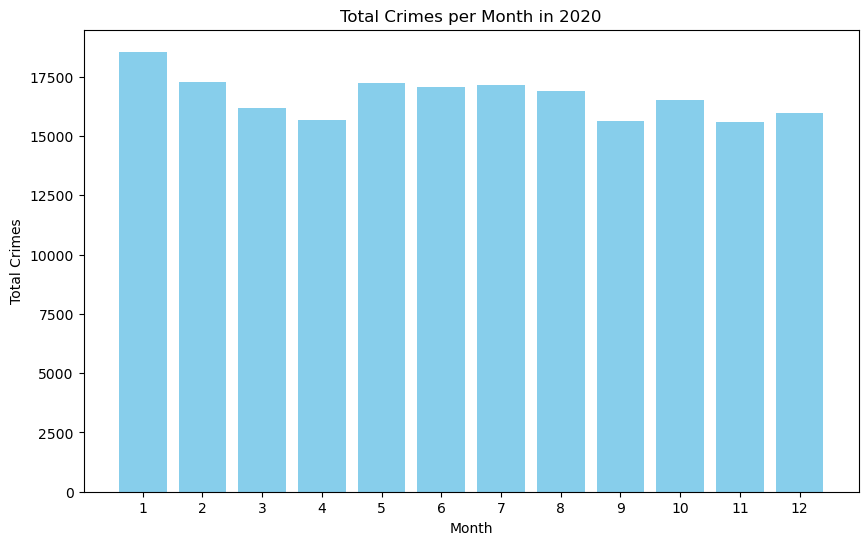

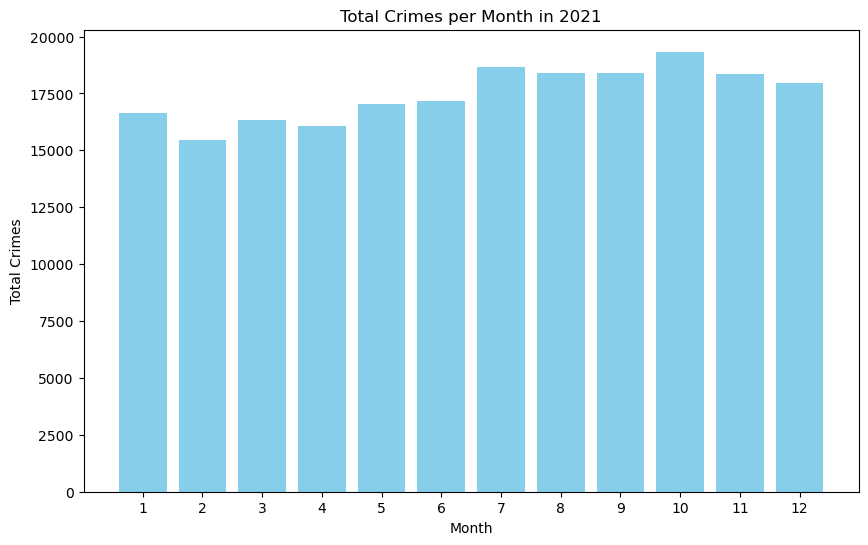

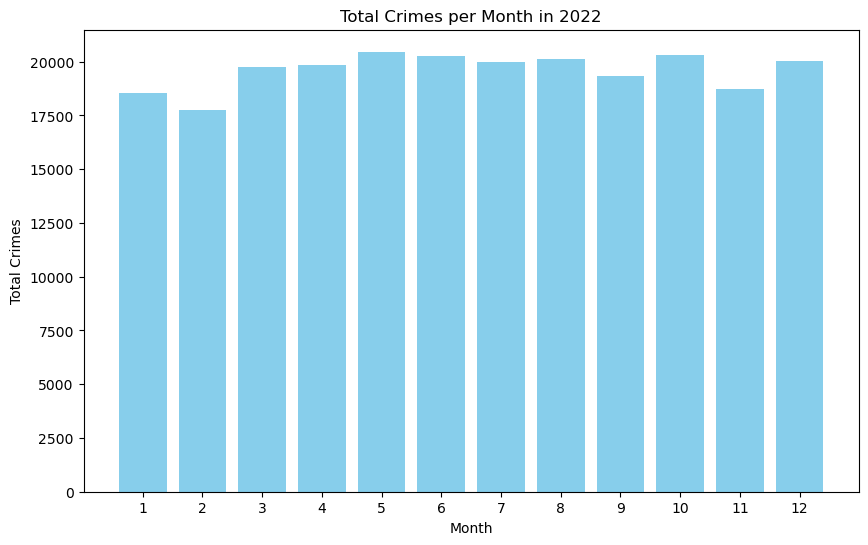

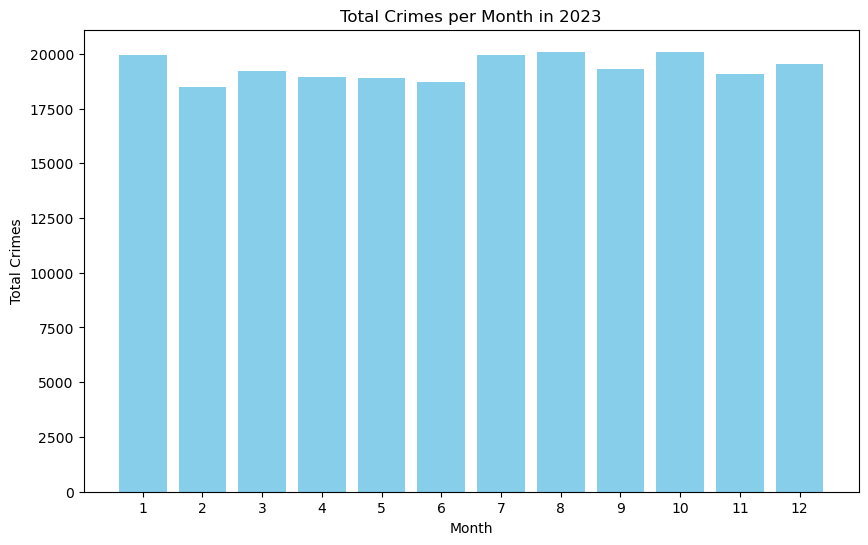

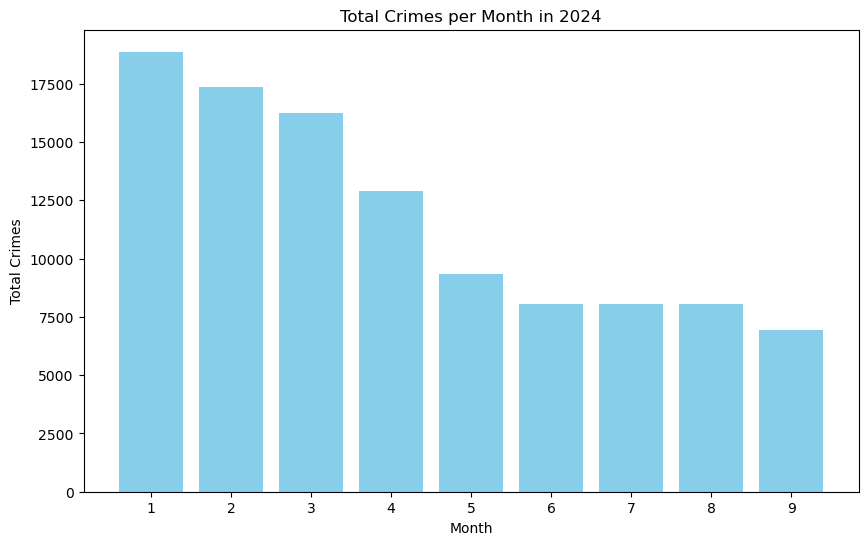

In [13]:
for yr in years_list:
    df_year = df_grouped.filter(df_grouped.year_occurred == yr)
    data_year = df_year.collect()

    months = [row["month_occurred"] for row in data_year]
    total_crimes = [row['frequency'] for row in data_year]

    plt.figure(figsize=(10,6))
    plt.bar(months, total_crimes, color='skyblue')
    plt.xlabel("Month")
    plt.ylabel("Total Crimes")
    plt.title(f"Total Crimes per Month in {yr}")
    plt.xticks(months)
    plt.show()

Crime frequency for each month is about the same.

In [14]:
df_year_total = df.groupBy("year_occurred").agg(F.count("year_occurred").alias("total_each_year"))
df_year_total.show()

+-------------+---------------+
|year_occurred|total_each_year|
+-------------+---------------+
|         2020|         199787|
|         2021|         209805|
|         2022|         235152|
|         2023|         232130|
|         2024|         105764|
+-------------+---------------+



The number of crimes is increasing from 2020 to 2022 but decrease in 2023. Not a lot by decrease. 

The number in year 2024 is not complete. 

In [15]:
# grouping the crime according to crime code etc
df_crime_cat = df.groupBy("year_occurred", "Crm Cd Desc").agg(F.count("year_occurred").alias("crime_cat_by_year")).orderBy("crime_cat_by_year", ascending=False)
df_crime_cat.show()

+-------------+--------------------+-----------------+
|year_occurred|         Crm Cd Desc|crime_cat_by_year|
+-------------+--------------------+-----------------+
|         2022|    VEHICLE - STOLEN|            24742|
|         2023|    VEHICLE - STOLEN|            24464|
|         2021|    VEHICLE - STOLEN|            23683|
|         2022|   THEFT OF IDENTITY|            22130|
|         2020|    VEHICLE - STOLEN|            20771|
|         2023|BATTERY - SIMPLE ...|            18834|
|         2022|BATTERY - SIMPLE ...|            18058|
|         2024|    VEHICLE - STOLEN|            17144|
|         2020|BATTERY - SIMPLE ...|            16331|
|         2021|BATTERY - SIMPLE ...|            16199|
|         2023|            BURGLARY|            14287|
|         2022|BURGLARY FROM VEH...|            14231|
|         2022|            BURGLARY|            14069|
|         2021|VANDALISM - FELON...|            13681|
|         2023|BURGLARY FROM VEH...|            13556|
|         

In [16]:
# grouping the crime according to crime code etc
df_crime_cat = df.groupBy("year_occurred", "Crm Cd Desc").agg(F.count("year_occurred").alias("crime_cat_by_year")).orderBy(["year_occurred", "crime_cat_by_year"])
df_crime_cat.show()

+-------------+--------------------+-----------------+
|year_occurred|         Crm Cd Desc|crime_cat_by_year|
+-------------+--------------------+-----------------+
|         2020|             BRIBERY|                1|
|         2020|GRAND THEFT / AUT...|                1|
|         2020|FIREARMS RESTRAIN...|                1|
|         2020| PICKPOCKET, ATTEMPT|                1|
|         2020|TILL TAP - GRAND ...|                2|
|         2020|GRAND THEFT / INS...|                2|
|         2020|PURSE SNATCHING -...|                3|
|         2020|BIKE - ATTEMPTED ...|                3|
|         2020|THEFT, COIN MACHI...|                3|
|         2020|   CHILD ABANDONMENT|                3|
|         2020|LYNCHING - ATTEMPTED|                4|
|         2020|PETTY THEFT - AUT...|                4|
|         2020|MANSLAUGHTER, NEG...|                4|
|         2020|TILL TAP - PETTY ...|                4|
|         2020|          DRUNK ROLL|                4|
|         

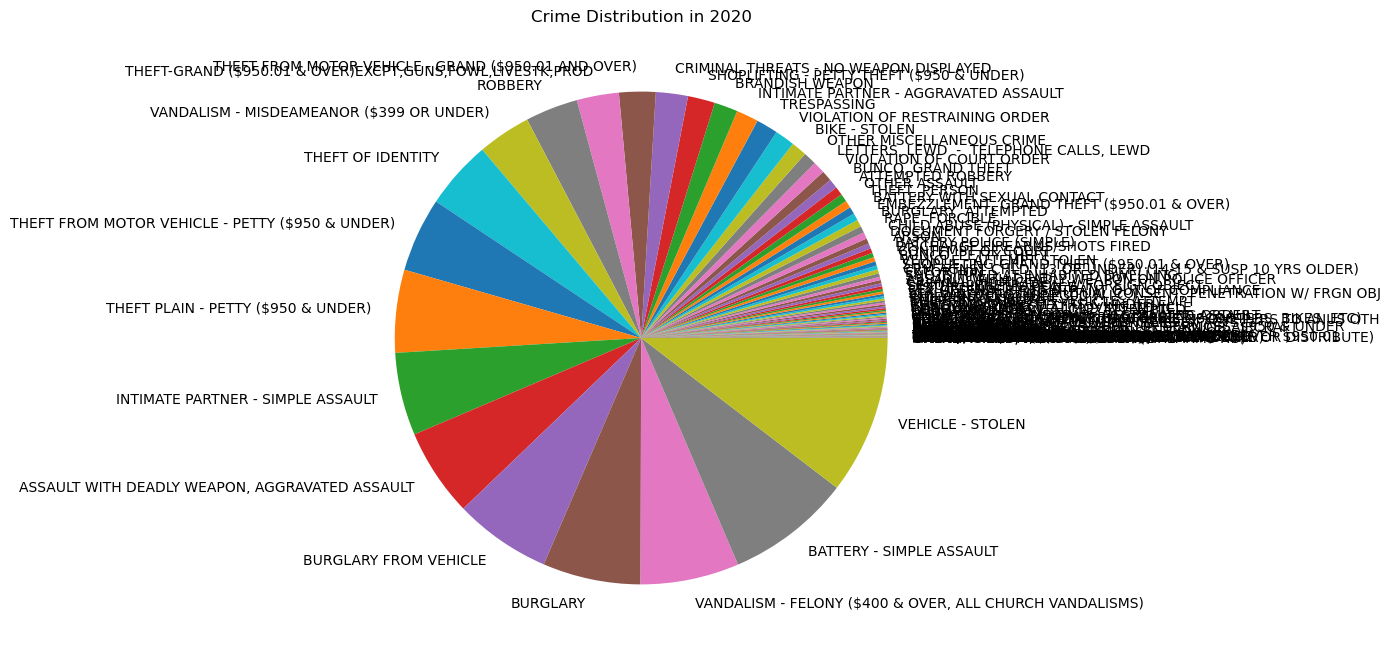

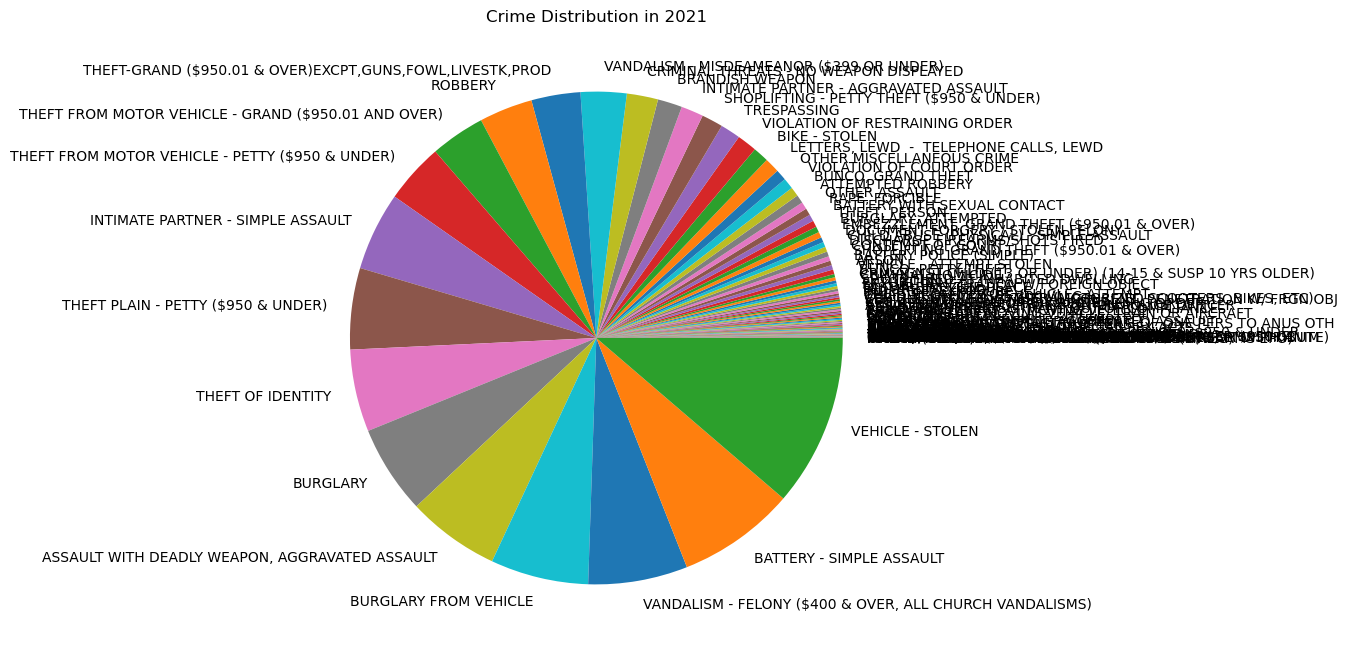

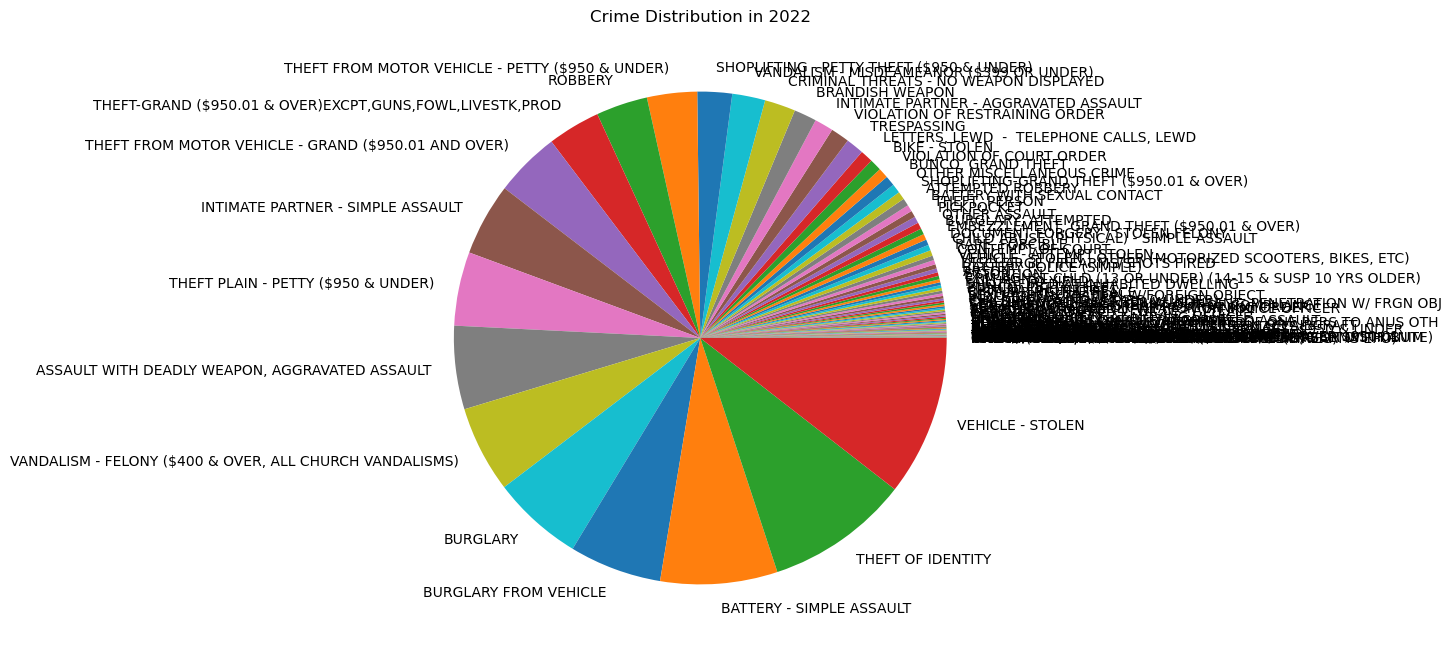

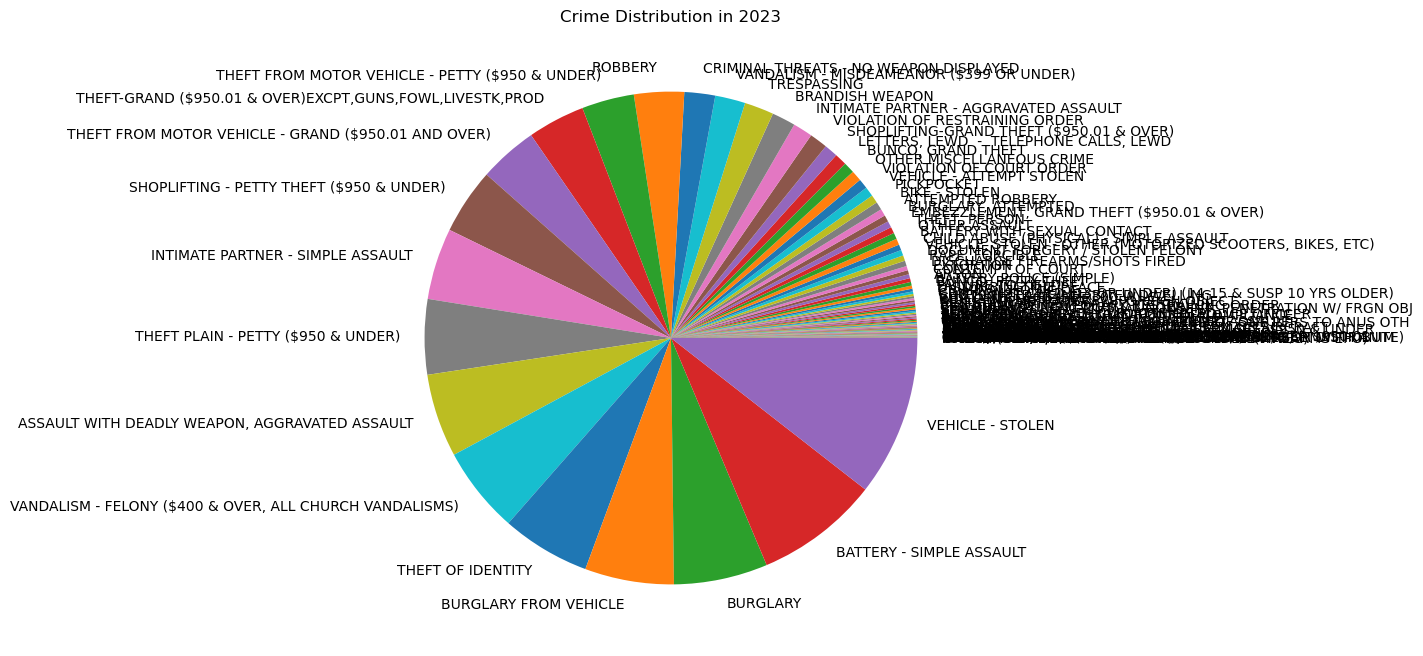

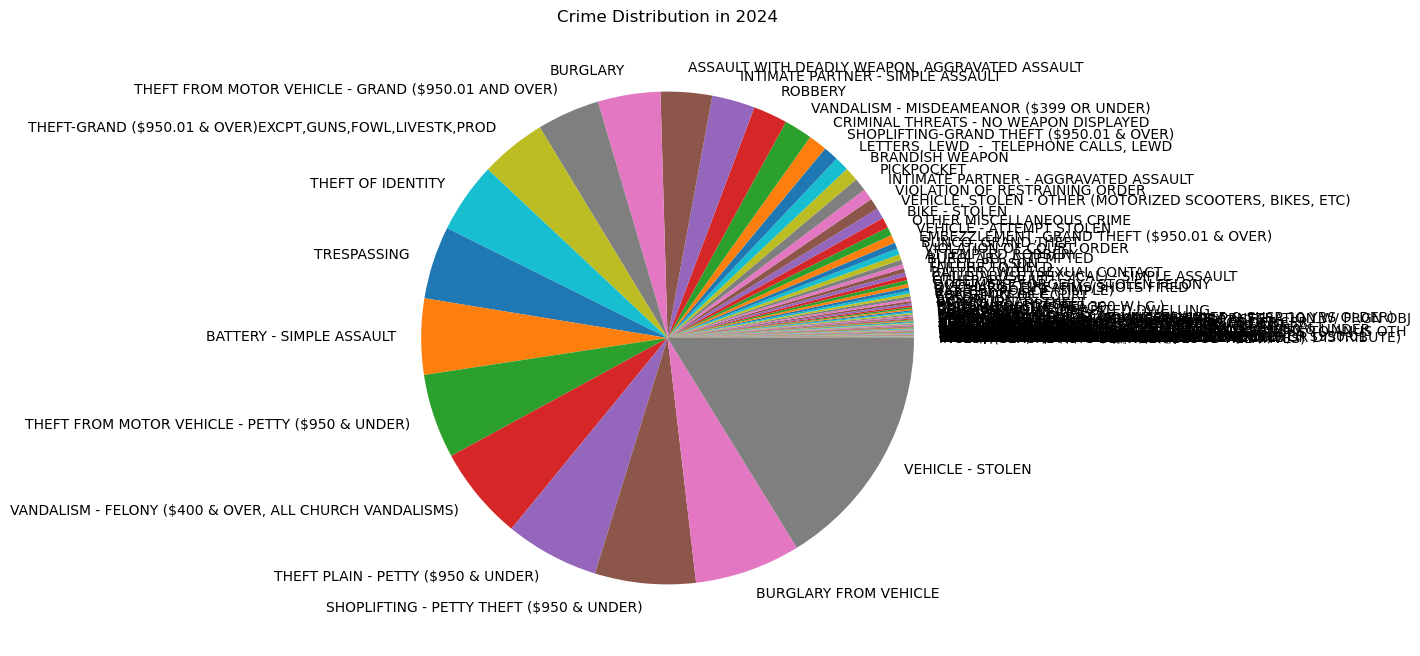

In [17]:
for yr in years_list:
    df_crime_year = df_crime_cat.filter(df_crime_cat.year_occurred == yr)
    data_crime_year = df_crime_year.collect()

    labels = [row["Crm Cd Desc"] for row in data_crime_year]
    sizes = [row['crime_cat_by_year'] for row in data_crime_year]

    plt.figure(figsize=(8,8))
    plt.pie(sizes, labels=labels)
    plt.title(f"Crime Distribution in {yr}")
    plt.show()

In [18]:
m = folium.Map(location=[34.0522, -118.2437], zoom_start=15)

df_2020 = df.filter(df.year_occurred == 2020).filter(df["Crm Cd"] == "110")
print(df_2020.count())
lat_lon_data = df_2020.select("LAT", "LON").rdd.map(lambda row: (row[0], row[1])).collect()

HeatMap(lat_lon_data).add_to(m)

m

352
